In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster
import leafmap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from kneed import KneeLocator

/tmp/ipykernel_1594/1250589311.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/opt/conda/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For

In [2]:
schema = 'projects_research'
table = 'arroyovivo_residuos_hex'
query = f"SELECT * FROM {schema}.{table}"
residuos = aup.gdf_from_query(query, geometry_col='geometry')

print(residuos.shape)
residuos.head(1)

(562, 51)


,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,24.0,0.0,0.0,36.0,44.0,0.0,...,207.0,259.0,89.0,137.0,1.0,1.0,1918.0,Plastico,2669.0,Plastico_quantity


In [4]:
residuos.columns

Index(['hex_id', 'res', 'geometry', 'aluminio', 'aluminio_quantity',
       'baterias', 'baterias_quantity', 'carton', 'carton_quantity', 'cenizas',
       'cenizas_quantity', 'ceramica', 'ceramica_quantity', 'electronica',
       'electronica_quantity', 'escombros', 'escombros_quantity', 'goma',
       'goma_quantity', 'llantas', 'llantas_quantity', 'madera',
       'madera_quantity', 'metal', 'metal_quantity', 'organico',
       'organico_quantity', 'otros', 'otros_quantity', 'papel',
       'papel_quantity', 'pesca', 'pesca_quantity', 'plastico',
       'plastico_quantity', 'salud e higiene', 'salud e higiene_quantity',
       'tabaco', 'tabaco_quantity', 'tela', 'tela_quantity', 'unicel',
       'unicel_quantity', 'vidrio', 'vidrio_quantity', 'epi', 'epi_quantity',
       'total_points', 'most_common_point', 'total_quantity',
       'most_common_quantity'],
      dtype='object')

## Dividir Data Sets en Material y Material_quantity

### DataFrame Material

In [3]:
col_material = ['hex_id', 'geometry', 'aluminio', 'baterias', 'carton','cenizas','ceramica','electronica','escombros',
                'goma','llantas','madera','metal','organico','otros','papel','pesca','plastico','salud e higiene',
                'tabaco','tela','unicel','vidrio','epi','total_points', 'most_common_point'] 
data_material = residuos[col_material].copy()
print(data_material.shape)
data_material.head(2)

(562, 26)


,hex_id,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,goma,...,pesca,plastico,salud e higiene,tabaco,tela,unicel,vidrio,epi,total_points,most_common_point
0,8a48a20296a7fff,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,0.0,36.0,0.0,10.0,1.0,21.0,0.0,...,0.0,1202.0,29.0,13.0,84.0,207.0,89.0,1.0,1918.0,Plastico
1,8a48a202978ffff,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",10.0,0.0,13.0,2.0,2.0,2.0,25.0,2.0,...,0.0,760.0,12.0,7.0,81.0,57.0,26.0,0.0,1122.0,Plastico


In [4]:
data_material.columns

Index(['hex_id', 'geometry', 'aluminio', 'baterias', 'carton', 'cenizas',
       'ceramica', 'electronica', 'escombros', 'goma', 'llantas', 'madera',
       'metal', 'organico', 'otros', 'papel', 'pesca', 'plastico',
       'salud e higiene', 'tabaco', 'tela', 'unicel', 'vidrio', 'epi',
       'total_points', 'most_common_point'],
      dtype='object')

### K-Means Clustering

### K-Value

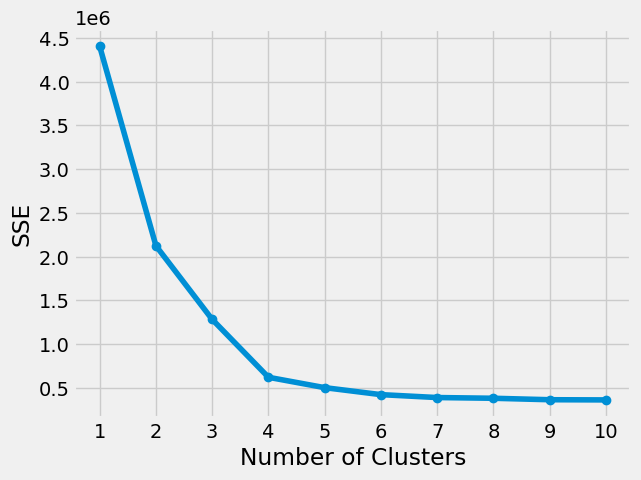

In [5]:
colclustering = ['aluminio', 'baterias', 'carton', 'cenizas', 'ceramica', 'electronica',
                           'escombros', 'goma', 'llantas', 'madera', 'metal', 'organico', 'otros',
                           'papel', 'pesca', 'plastico', 'salud e higiene', 'tabaco', 'tela', 'unicel',
                           'vidrio', 'epi']
kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

sse = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_material[colclustering])
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [6]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)
k_value = kl.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {k_value}')

El valor óptimo de clusters basado en la data que tenemos es 4


### Cluster

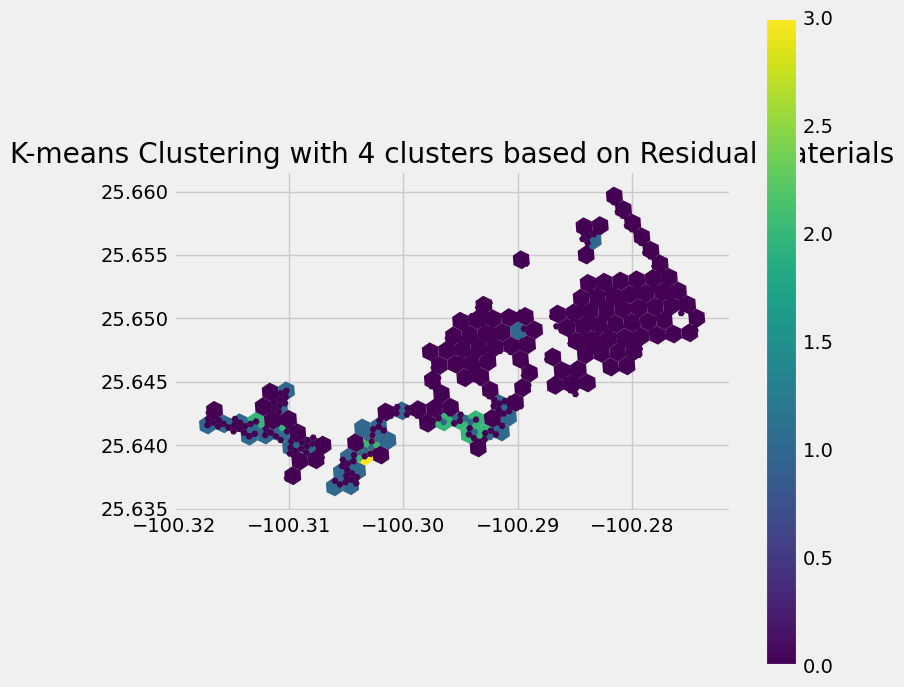

In [17]:
k =  k_value


kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
data_material['cluster'] = kmeans.fit_predict(data_material[colclustering])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_material.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {k} clusters based on Residual Materials')
plt.show()

In [18]:
data_material['cluster'].unique()

array([3, 2, 1, 0], dtype=int32)

### 3 residuos más importantes para cada hexágono

In [19]:
imp_var = ['aluminio', 'baterias', 'carton','cenizas','ceramica','electronica','escombros','goma',
           'llantas','madera','metal','organico','otros','papel','pesca','plastico','salud e higiene',
           'tabaco','tela','unicel','vidrio','epi'] 

#lista_hex = data_material['hex_id'].tolist()
lista_top3_maximos = []
lista_top3_materiales = []
cantidad_filas = data_material.shape[0]

for i in range(cantidad_filas):
    #hex_id = lista_hex[i]
    fila_seleccionada = data_material.iloc[i, 2:-2]
    
    # Sort the residuals and get the top 3 values and corresponding materials
    sorted_residuos = sorted(zip(fila_seleccionada, imp_var), reverse=True)
    top3_maximos = sorted_residuos[:3]
    
    # Separate the top 3 values and materials into separate lists
    top3_maximos_valores, top3_maximos_materiales = zip(*top3_maximos)
    
    lista_top3_maximos.append(top3_maximos_valores)
    lista_top3_materiales.append(top3_maximos_materiales)
    
    # Print the results if needed
    #print(f'Top 3 residuals of hexagon {hex_id} ({i}): {top3_maximos}')

# Add the lists to the DataFrame
data_material['top3_maximos'] = lista_top3_maximos
data_material['top3_materiales'] = lista_top3_materiales
data_material.head()

,hex_id,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,goma,...,tabaco,tela,unicel,vidrio,epi,total_points,most_common_point,cluster,top3_maximos,top3_materiales
0,8a48a20296a7fff,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,0.0,36.0,0.0,10.0,1.0,21.0,0.0,...,13.0,84.0,207.0,89.0,1.0,1918.0,Plastico,3,"(1202.0, 207.0, 108.0)","(plastico, unicel, metal)"
1,8a48a202978ffff,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",10.0,0.0,13.0,2.0,2.0,2.0,25.0,2.0,...,7.0,81.0,57.0,26.0,0.0,1122.0,Plastico,3,"(760.0, 81.0, 67.0)","(plastico, tela, papel)"
2,8a48a202baaffff,"POLYGON ((-100.29357 25.64128, -100.29289 25.6...",0.0,0.0,5.0,0.0,0.0,0.0,156.0,0.0,...,0.0,173.0,3.0,4.0,0.0,847.0,Plastico,2,"(321.0, 174.0, 173.0)","(plastico, papel, tela)"
3,8a48a202ba1ffff,"POLYGON ((-100.29499 25.64119, -100.29431 25.6...",3.0,0.0,1.0,0.0,2.0,0.0,170.0,1.0,...,2.0,15.0,16.0,53.0,0.0,810.0,Plastico,2,"(379.0, 170.0, 147.0)","(plastico, escombros, papel)"
4,8a48a202ba0ffff,"POLYGON ((-100.29641 25.64109, -100.29573 25.6...",1.0,0.0,2.0,0.0,1.0,0.0,155.0,0.0,...,0.0,66.0,13.0,19.0,0.0,708.0,Plastico,2,"(364.0, 155.0, 66.0)","(plastico, escombros, tela)"


## Mapa Interactivo

In [15]:
import folium
from folium import GeoJson
import matplotlib.cm as cm
from matplotlib.colors import to_hex

# Unique values of 'Material(es)'
unique_materials = data_material['cluster'].unique()

# Create a colormap with a color for each unique value
color_map = cm.get_cmap('Accent', len(unique_materials))

# Create a color mapping dictionary
color_mapping = {material: to_hex(color_map(i)) for i, material in enumerate(unique_materials)}

# Create a function to get the color based on the 'Material(es)' value
def get_color(feature):
    material_value = feature['properties']['cluster']
    return color_mapping.get(material_value, 'gray')

# Create a map centered at the mean coordinates
m = folium.Map(location=[data_material['geometry'].centroid.y.mean(), data_material['geometry'].centroid.x.mean()], zoom_start=14.45)

# Add GeoJson layer with styling based on 'Material(es)'
geojson_layer = GeoJson(data_material,
                        style_function=lambda feature: {
                            'fillColor': get_color(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_point','top3_materiales', 'cluster'], labels=True, sticky=True)
                       ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

#Save the map
m.save("Arroyo_Vivo_MaterialesKMeans.html")

# Show the map
m

### DataFrame Material_quantity

In [20]:
col_qty = ['hex_id', 'geometry', 'aluminio_quantity', 'baterias_quantity', 'carton_quantity','cenizas_quantity',
                  'ceramica_quantity','electronica_quantity','escombros_quantity','goma_quantity','llantas_quantity', 
                  'madera_quantity','metal_quantity','organico_quantity','otros_quantity','papel_quantity','pesca_quantity',
                  'plastico_quantity','salud e higiene_quantity','tabaco_quantity','tela_quantity','unicel_quantity',
                  'vidrio_quantity','epi_quantity','total_quantity','most_common_quantity'] 
data_quantity = residuos[col_qty].copy()
print(data_quantity.shape)
data_quantity.head(2)

(562, 26)


,hex_id,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,goma_quantity,...,pesca_quantity,plastico_quantity,salud e higiene_quantity,tabaco_quantity,tela_quantity,unicel_quantity,vidrio_quantity,epi_quantity,total_quantity,most_common_quantity
0,8a48a20296a7fff,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",24.0,0.0,44.0,0.0,52.0,2.0,39.0,0.0,...,0.0,1479.0,37.0,21.0,108.0,259.0,137.0,1.0,2669.0,Plastico_quantity
1,8a48a202978ffff,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",33.0,0.0,15.0,2.0,5.0,5.0,59.0,2.0,...,0.0,1640.0,38.0,7.0,170.0,238.0,55.0,0.0,2473.0,Plastico_quantity


In [21]:
data_quantity.columns

Index(['hex_id', 'geometry', 'aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity', 'total_quantity',
       'most_common_quantity'],
      dtype='object')

## K-Means Clustering

### K-Value

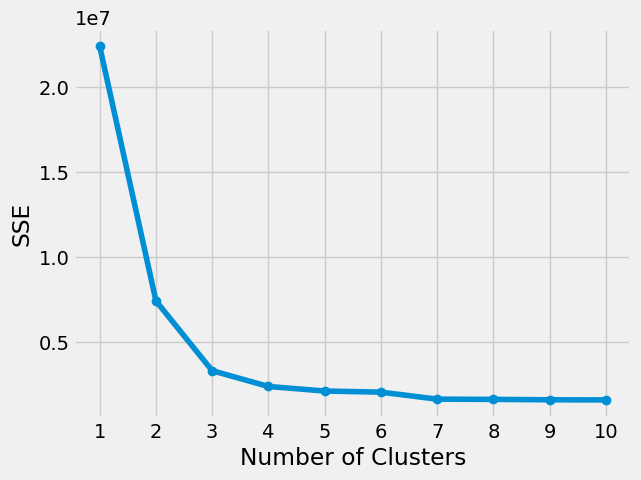

In [22]:
colclust = ['aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity']
kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

SSE = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_quantity[colclust])
    SSE.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), SSE, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [23]:
KL = KneeLocator(
    range(1, 11), SSE, curve="convex", direction="decreasing"
)
K_value = KL.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {K_value}')

El valor óptimo de clusters basado en la data que tenemos es 3


### Cluster

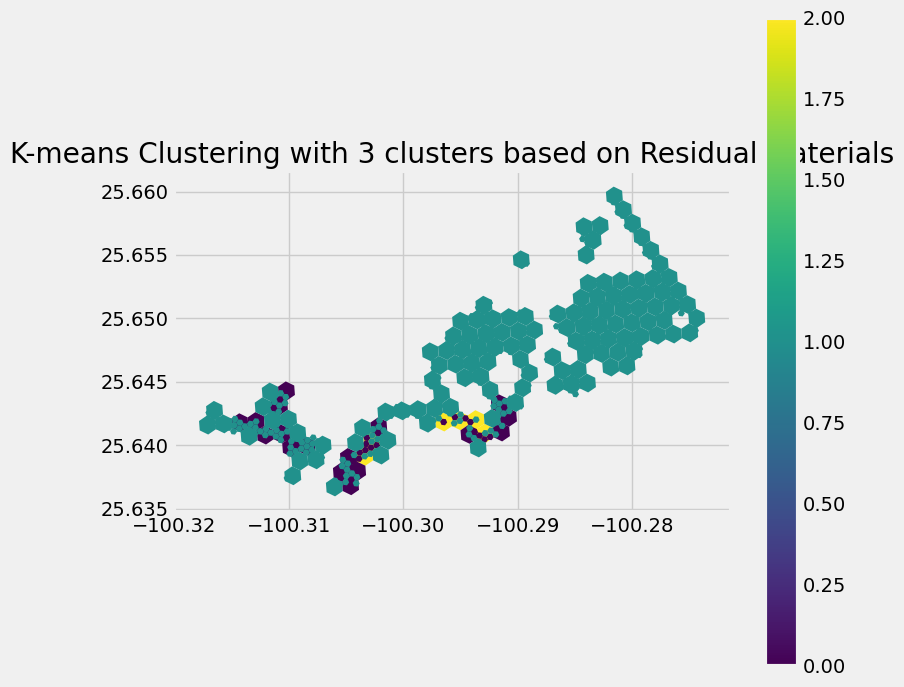

In [25]:
K =  K_value


kmeans = KMeans(n_clusters=K, **kmeans_kwargs)
data_quantity['cluster'] = kmeans.fit_predict(data_quantity[colclust])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_quantity.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {K} clusters based on Residual Materials')
plt.show()

In [26]:
data_quantity['cluster'].unique()

array([2, 0, 1], dtype=int32)

### 3 residuos más importantes para cada hexágono

In [28]:
imp_var_qty = ['aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity']

#lista_hex = data_material['hex_id'].tolist()
lista_top3_maximos = []
lista_top3_materiales = []
cantidad_filas = data_quantity.shape[0]

for i in range(cantidad_filas):
    #hex_id = lista_hex[i]
    fila_seleccionada = data_quantity.iloc[i, 2:-2]
    
    # Sort the residuals and get the top 3 values and corresponding materials
    sorted_residuos = sorted(zip(fila_seleccionada, imp_var_qty), reverse=True)
    top3_maximos = sorted_residuos[:3]
    
    # Separate the top 3 values and materials into separate lists
    top3_maximos_valores, top3_maximos_materiales = zip(*top3_maximos)
    
    lista_top3_maximos.append(top3_maximos_valores)
    lista_top3_materiales.append(top3_maximos_materiales)
    
    # Print the results if needed
    #print(f'Top 3 residuals of hexagon {hex_id} ({i}): {top3_maximos}')

# Add the lists to the DataFrame
data_quantity['top3_maximos_qty'] = lista_top3_maximos
data_quantity['top3_materiales_qty'] = lista_top3_materiales
data_quantity.head()

,hex_id,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,goma_quantity,...,unicel_quantity,vidrio_quantity,epi_quantity,total_quantity,most_common_quantity,cluster,top3_maximos,top3_materiales,top3_maximos_qty,top3_materiales_qty
0,8a48a20296a7fff,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",24.0,0.0,44.0,0.0,52.0,2.0,39.0,0.0,...,259.0,137.0,1.0,2669.0,Plastico_quantity,2,"(1479.0, 297.0, 259.0)","(plastico_quantity, metal_quantity, unicel_qua...","(1479.0, 297.0, 259.0)","(plastico_quantity, metal_quantity, unicel_qua..."
1,8a48a202978ffff,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",33.0,0.0,15.0,2.0,5.0,5.0,59.0,2.0,...,238.0,55.0,0.0,2473.0,Plastico_quantity,2,"(1640.0, 238.0, 170.0)","(plastico_quantity, unicel_quantity, tela_quan...","(1640.0, 238.0, 170.0)","(plastico_quantity, unicel_quantity, tela_quan..."
2,8a48a202baaffff,"POLYGON ((-100.29357 25.64128, -100.29289 25.6...",0.0,0.0,26.0,0.0,0.0,0.0,156.0,0.0,...,39.0,9.0,0.0,2994.0,Plastico_quantity,2,"(1787.0, 759.0, 195.0)","(plastico_quantity, tela_quantity, papel_quant...","(1787.0, 759.0, 195.0)","(plastico_quantity, tela_quantity, papel_quant..."
3,8a48a202ba1ffff,"POLYGON ((-100.29499 25.64119, -100.29431 25.6...",3.0,0.0,1.0,0.0,2.0,0.0,173.0,1.0,...,27.0,53.0,0.0,1672.0,Plastico_quantity,2,"(1200.0, 173.0, 149.0)","(plastico_quantity, escombros_quantity, papel_...","(1200.0, 173.0, 149.0)","(plastico_quantity, escombros_quantity, papel_..."
4,8a48a202ba0ffff,"POLYGON ((-100.29641 25.64109, -100.29573 25.6...",1.0,0.0,2.0,0.0,1.0,0.0,203.0,0.0,...,25.0,39.0,0.0,1820.0,Plastico_quantity,2,"(1363.0, 203.0, 88.0)","(plastico_quantity, escombros_quantity, papel_...","(1363.0, 203.0, 88.0)","(plastico_quantity, escombros_quantity, papel_..."


### Mapa Interactivo

In [30]:
# Unique values of 'Material(es)'
unique_materials = data_quantity['cluster'].unique()

# Create a colormap with a color for each unique value
color_map = cm.get_cmap('Accent', len(unique_materials))

# Create a color mapping dictionary
color_mapping = {material: to_hex(color_map(i)) for i, material in enumerate(unique_materials)}

# Create a function to get the color based on the 'Material(es)' value
def get_color(feature):
    material_value = feature['properties']['cluster']
    return color_mapping.get(material_value, 'gray')

# Create a map centered at the mean coordinates
m = folium.Map(location=[data_quantity['geometry'].centroid.y.mean(), data_quantity['geometry'].centroid.x.mean()], zoom_start=14.45)

# Add GeoJson layer with styling based on 'Material(es)'
geojson_layer = GeoJson(data_quantity,
                        style_function=lambda feature: {
                            'fillColor': get_color(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_quantity','top3_materiales_qty', 'cluster'], labels=True, sticky=True)
                       ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

#Save the map
m.save("Arroyo_Vivo_MaterialesqtyKMeans.html")

# Show the map
m

## DualMap para comparar

In [35]:
import folium
from folium.plugins import DualMap, MarkerCluster
from folium import GeoJson
import matplotlib.cm as cm
from matplotlib.colors import to_hex

# Define a function to create a GeoJson layer
def create_geojson_layer(data, color_mapping, tooltip_fields):
    return GeoJson(data,
                   style_function=lambda feature: {
                       'fillColor': color_mapping.get(feature['properties']['cluster'], 'gray'),
                       'color': 'black',
                       'weight': 1,
                       'fillOpacity': 0.6,
                   },
                   highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                   tooltip=folium.GeoJsonTooltip(fields=tooltip_fields, labels=True, sticky=True))

# Unique values of 'Material(es)' for the first map
unique_materials_1 = data_material['cluster'].unique()

# Create a colormap with a color for each unique value
color_map_1 = cm.get_cmap('Accent', len(unique_materials_1))

# Create a color mapping dictionary for the first map
color_mapping_1 = {material: to_hex(color_map_1(i)) for i, material in enumerate(unique_materials_1)}

# Create the first map centered at the mean coordinates
map1 = create_geojson_layer(data_material,
                             color_mapping_1,
                             ['most_common_point', 'top3_materiales', 'cluster'])

# Unique values of 'Material(es)' for the second map
unique_materials_2 = data_quantity['cluster'].unique()

# Create a colormap with a color for each unique value for the second map
color_map_2 = cm.get_cmap('Accent', len(unique_materials_2))

# Create a color mapping dictionary for the second map
color_mapping_2 = {material: to_hex(color_map_2(i)) for i, material in enumerate(unique_materials_2)}

# Create the second map centered at the mean coordinates
map2 = create_geojson_layer(data_quantity,
                             color_mapping_2,
                             ['most_common_quantity', 'top3_materiales_qty', 'cluster'])

# Create the dual map
dual_map = DualMap(location=[data_material['geometry'].centroid.y.mean(),
                              data_material['geometry'].centroid.x.mean()],
                   tiles='OpenStreetMap',
                   zoom_start=14)

# Add GeoJson layers to the respective maps
map1.add_to(dual_map.m1)
map2.add_to(dual_map.m2)

# Add layer control to each map
folium.LayerControl().add_to(dual_map.m1)
folium.LayerControl().add_to(dual_map.m2)

# Save the dual map
dual_map.save("Arroyo_Vivo_ComparaciónMaterial_PuntoVSQuantity.html")

# Show the dual map
dual_map
